In [1]:
import os, sys, re, gc, glob

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix
import json

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from tqdm.auto import tqdm, trange
from utils import JDNDataset, JDIModel, get_grey_image, assign_labels, logger, maximize_window, DatasetBuilder, load_gray_image
from time import sleep
from flask import jsonify

import datetime as dt
import requests

START_DT = dt.datetime.now()

2021-06-21 13:25:00,569 -INFO - config:config.py:16 - Module utils.config was loaded
2021-06-21 13:25:00,571 -INFO - common:common.py:618 - Module utils.common is loaded...
2021-06-21 13:25:00,572 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-06-21 13:25:00,579 -INFO - features_builder:features_builder.py:305 - feature_bilder module is loaded...
2021-06-21 13:25:00,581 -INFO - dataset_builder:dataset_builder.py:207 - dataset package is loaded...
2021-06-21 13:25:00,583 -INFO - dataset:dataset.py:277 - dataset module is loaded...


In [2]:
SITE_URL = 'https://jdi-testing.github.io/jdi-light/'
PREDICT_URL = 'http://localhost:5000/predict'

LOGIN = 'Roman'
PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False

### getting json

In [3]:
DATASET_NAME = 'dummy'

2021-06-21 13:25:00,895 -WARNING - dataset_builder:dataset_builder.py:75 - The default dataset name "dummy" will be used
2021-06-21 13:25:00,896 -INFO - dataset_builder:dataset_builder.py:86 - Create directories to save the dataset
2021-06-21 13:25:00,897 -INFO - dataset_builder:dataset_builder.py:123 - Creating driver
2021-06-21 13:25:02,076 -INFO - dataset_builder:dataset_builder.py:131 - Chrome web driver is created
2021-06-21 13:25:02,077 -INFO - <ipython-input-4-f337efb8bc71>:<ipython-input-4-f337efb8bc71>:4 - getting page
2021-06-21 13:25:17,458 -INFO - common:common.py:75 - Window maximized
2021-06-21 13:25:24,474 -INFO - dataset_builder:dataset_builder.py:134 - save scrinshot: dataset/images/dummy.png
2021-06-21 13:25:24,803 -INFO - dataset_builder:dataset_builder.py:178 - Collect features using JS script
2021-06-21 13:25:25,297 -INFO - dataset_builder:dataset_builder.py:186 - Save html to dataset/html/dummy.html
2021-06-21 13:25:25,306 -INFO - dataset_builder:dataset_builder.p

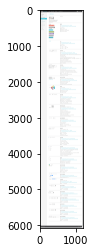

In [4]:
class JDIDatasetBuilder(DatasetBuilder):

    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_URL)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Elements packs").click()
        driver.find_element_by_link_text("Mobile and HTML 5").click()
        sleep(WAIT_TIME_SECONDS)
        
#         driver.find_element_by_link_text("Service").click()
#         driver.find_element_by_link_text("Complex Table").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)
        

with JDIDatasetBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))
    login_json = builder.dataset_json
  

In [5]:
PREDICT_URL

'http://localhost:5000/predict'

### Predict: sending json to backend and getting predictions

In [6]:
%%time

response = requests.post(
    PREDICT_URL, data=json.dumps(login_json)
)

if response.status_code == 200:
    display(json.loads(response.text))
else:
    raise Exception(response.text)

[{'element_id': '8735803254711248088357843637',
  'x': 240.0,
  'y': 1539.0,
  'width': 217.0,
  'height': 56.0,
  'predicted_label': 'textarea',
  'predicted_probability': 0.9999998808,
  'sort_key': 12152.0},
 {'element_id': '6672487431711248086871199671',
  'x': 600.140625,
  'y': 5283.0,
  'width': 492.015625,
  'height': 18.0,
  'predicted_label': 'link',
  'predicted_probability': 0.8414088488,
  'sort_key': 8856.28125},
 {'element_id': '3356736659711248084621519166',
  'x': 502.859375,
  'y': 0.0,
  'width': 140.484375,
  'height': 60.0,
  'predicted_label': 'link',
  'predicted_probability': 0.9947745204,
  'sort_key': 8429.0625},
 {'element_id': '2821178719711248084451926829',
  'x': 600.140625,
  'y': 3599.0,
  'width': 462.5,
  'height': 18.0,
  'predicted_label': 'link',
  'predicted_probability': 0.8414088488,
  'sort_key': 8325.0},
 {'element_id': '9491841569711248084682058864',
  'x': 600.140625,
  'y': 3855.0,
  'width': 462.5,
  'height': 18.0,
  'predicted_label': 'li

Wall time: 3.04 s


In [7]:
response

<Response [200]>

In [8]:
print('Elapsed time:', dt.datetime.now() - START_DT)

Elapsed time: 0:00:28.285795


In [9]:
predictions_df = pd.DataFrame(json.loads(response.text))


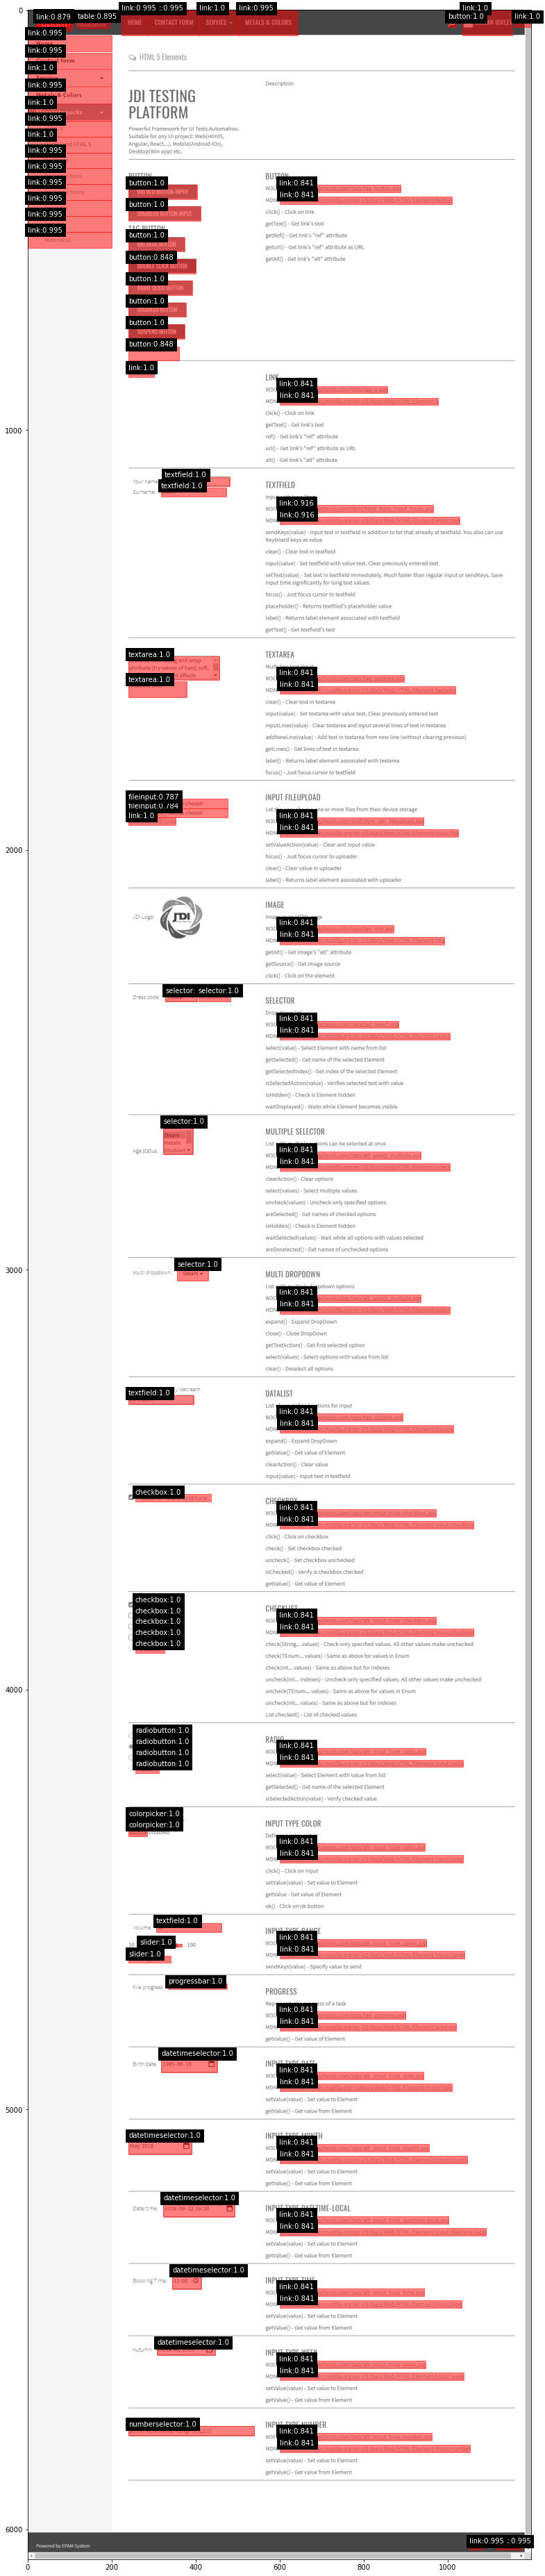

In [10]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
plt.figure(figsize=(13,300))
plt.imshow(img, cmap='gray')

axes = plt.gca()

for _, r in predictions_df.iterrows():
    patch = Rectangle((r.x, r.y), r.width, r.height, alpha=.5, color='red')
    axes.add_patch(patch)
    
    axes.text(r.x, r.y, r.predicted_label + ':' +str(round(r.predicted_probability, 3)), backgroundcolor='black', color='white')
    